In [151]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


import os
import re
from string import punctuation

from nltk.stem.snowball import SnowballStemmer
from pymorphy2 import MorphAnalyzer

import random

from torch import nn, optim
from torchvision import transforms

In [152]:
df = pd.read_csv('archive/train.csv')

In [153]:
df.isna().sum()

id       0
label    0
tweet    0
dtype: int64

In [154]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [155]:
df = df[['label','tweet']]

In [156]:
df = df.drop_duplicates(keep='first')

In [157]:
df.shape

(29530, 2)

In [158]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/anna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [159]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/anna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [160]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer(language='english')

In [161]:
def transformer(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'ð', ' ', text)
    filtered_tokens = []
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    for token in tokens:
        if token not in stop_words and token != " " and token.strip() not in punctuation:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens if t not in stop_words]
    new_text = ' '.join(stems)

    return new_text

In [176]:
train_corpus = " ".join(df["tweet"])
train_corpus = train_corpus.lower()

In [189]:
tokens = [word for sent in nltk.sent_tokenize(train_corpus) for word in nltk.word_tokenize(sent)]

In [196]:
from nltk.probability import FreqDist
dist = FreqDist(tokens)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [199]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [202]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [203]:
df['tweet'] = df['tweet'].apply(transformer)

In [204]:
df.head()

,label,tweet
0,0,user father dysfunct selfish drag kid dysfunct...
1,0,user user thank lyft credit use caus offer whe...
2,0,bihday majesti
3,0,model love u take u time ur
4,0,factsguid societi motiv


In [219]:
X = df.drop('label', axis = 1)
y = df['label']

In [220]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, test_size=0.33)

In [221]:
max_words = 2000
max_len = 40
num_classes = 1

In [222]:
X_train = np.asarray([text_to_sequence(text, max_len) for text in X_train['tweet']])
X_valid = np.asarray([text_to_sequence(text, max_len) for text in X_valid['tweet']])

In [223]:
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [300]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim = 128, out_channel = 128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.conv_2(output)
        output = self.pool(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output

In [301]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [311]:
# Training
epochs = 10
batch_size = 512
print_batch_n = 100

In [312]:
model = Net(vocab_size=max_words)

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()
#model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.BCEWithLogitsLoss()

Net(
  (embedding): Embedding(2000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Parameters: 338305


In [313]:
train_dataset = DataWrapper(X_train, y_train.values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = DataWrapper(X_valid, y_valid.values)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [314]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [315]:
train_acc_history = []
test_acc_history = []

In [316]:
for epoch in range(epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            model.eval()
            
            train_acc_history.append(running_right / running_items)
            print(f'Epoch [{epoch + 1}/{epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0
            

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = model(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            test_acc_history.append(test_running_right / test_running_total)
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
        
        model.train()
        
print('Training is finished!')

Epoch [1/10]. Step [1/39]. Loss: 0.002. Acc: 0.924. Test acc: 0.931
Epoch [2/10]. Step [1/39]. Loss: 0.000. Acc: 0.918. Test acc: 0.931
Epoch [3/10]. Step [1/39]. Loss: 0.000. Acc: 0.938. Test acc: 0.931
Epoch [4/10]. Step [1/39]. Loss: 0.000. Acc: 0.936. Test acc: 0.931
Epoch [5/10]. Step [1/39]. Loss: 0.000. Acc: 0.938. Test acc: 0.931
Epoch [6/10]. Step [1/39]. Loss: 0.000. Acc: 0.932. Test acc: 0.931
Epoch [7/10]. Step [1/39]. Loss: 0.000. Acc: 0.938. Test acc: 0.931
Epoch [8/10]. Step [1/39]. Loss: 0.000. Acc: 0.938. Test acc: 0.931
Epoch [9/10]. Step [1/39]. Loss: 0.000. Acc: 0.918. Test acc: 0.931
Epoch [10/10]. Step [1/39]. Loss: 0.000. Acc: 0.928. Test acc: 0.931
Training is finished!


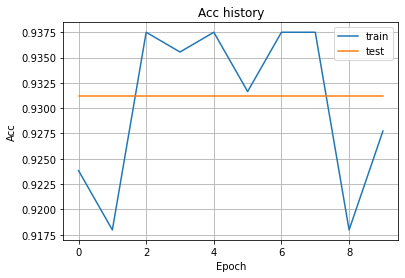

In [317]:
import matplotlib.pyplot as plt

plt.title('Acc history')
plt.grid(True)
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.plot(train_acc_history, label='train')
plt.plot(test_acc_history, label='test')
plt.legend();